### Author: Sophie Choe

#### Portland State University, Electrical and Computer Engineering
February 2022

Dependencies: keras-nightly==2.5.0.dev2021032900 PennyLane==0.17.0 StrawberryFields==0.18.0 tensorflow-2.4.0-cp38-cp38-macosx_10_9_x86_64.whl

# 5-qumode Classifier

Classical layers using keras dense and quantum layers using Pennylane

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

import pennylane as qml
import numpy as np

import matplotlib.pyplot as plt

## 0. Loading data

In [2]:
mnist = keras.datasets.mnist

# datasets are numpy.ndarrays
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()     

# normalize the image data
X_train, X_test = X_train / 255.0, X_test / 255.0

In [3]:
def one_hot(labels):  
       
    depth = 2**5                      # 2^5 = 32. 10 classes + 22 zeros for padding
    indices = labels.astype(np.int32)    
    one_hot_labels = np.eye(depth)[indices].astype(np.float32) 
    
    return one_hot_labels

# one-hot encoded labels, each label of length cutoff dimension**2
y_train, y_test = one_hot(Y_train), one_hot(Y_test)

# using only 600 samples for training in this experiment
n_samples = 600
test_samples = 100
X_train, X_test, y_train, y_test = X_train[:n_samples], X_test[:test_samples], y_train[:n_samples], y_test[:test_samples]

## 1. Classical circuit

In [4]:
keras.backend.set_floatx('float32')

model = keras.models.Sequential([
                                 layers.Flatten(input_shape = (28,28)),
                                 layers.Dense(128, activation ="elu"),
                                 layers.Dense(64, activation ="elu"),
                                 layers.Dense(38, activation ="elu"),
                                ])

# More than a million parameters for the classical circuit
model.summary()

## 2. Quantum data encoding

In [5]:
def encode_data(x):
    qml.Squeezing(x[0], x[1], wires=0)
    qml.Squeezing(x[2], x[3], wires=1)
    qml.Squeezing(x[4], x[5], wires=2)
    qml.Squeezing(x[6], x[7], wires=3)
    qml.Squeezing(x[8], x[9], wires=4)    
    
    qml.Beamsplitter(x[10], x[11], wires=[0,1])
    qml.Beamsplitter(x[12], x[13], wires=[1,2])
    qml.Beamsplitter(x[14], x[15], wires=[2,3])
    qml.Beamsplitter(x[16], x[17], wires=[3,4])    

    qml.Rotation(x[18], wires=0)
    qml.Rotation(x[19], wires=1)
    qml.Rotation(x[20], wires=2)
    qml.Rotation(x[21], wires=3)
    qml.Rotation(x[22], wires=4)
   
    qml.Displacement(x[23], x[24], wires=0)
    qml.Displacement(x[25], x[26], wires=1)
    qml.Displacement(x[27], x[28], wires=2)
    qml.Displacement(x[29], x[30], wires=3)
    qml.Displacement(x[31], x[32], wires=4)    
 
    qml.Kerr(x[33], wires=0)
    qml.Kerr(x[34], wires=1)
    qml.Kerr(x[35], wires=2)
    qml.Kerr(x[36], wires=3)
    qml.Kerr(x[37], wires=4)

## 3. Quantum neural network circuit

In [6]:
def qnn_layer(v):
    # Interferometer 1
    qml.Beamsplitter(v[0], v[1], wires=[0,1])
    qml.Beamsplitter(v[2], v[3], wires=[1,2])
    qml.Beamsplitter(v[4], v[5], wires=[2,3])
    qml.Beamsplitter(v[6], v[7], wires=[3,4])    

    qml.Rotation(v[8], wires=0)
    qml.Rotation(v[9], wires=1)
    qml.Rotation(v[10], wires=2)
    qml.Rotation(v[11], wires=3)
    qml.Rotation(v[12], wires=4)
    
    # Squeezers
    qml.Squeezing(v[13], 0.0, wires=0)
    qml.Squeezing(v[14], 0.0, wires=1)
    qml.Squeezing(v[15], 0.0, wires=2)
    qml.Squeezing(v[16], 0.0, wires=3)
    qml.Squeezing(v[17], 0.0, wires=4)
    
    # Interferometer 2
    qml.Beamsplitter(v[18], v[19], wires=[0,1])
    qml.Beamsplitter(v[20], v[21], wires=[1,2])
    qml.Beamsplitter(v[22], v[23], wires=[2,3])
    qml.Beamsplitter(v[24], v[25], wires=[3,4])

    qml.Rotation(v[26], wires=0)
    qml.Rotation(v[27], wires=1)
    qml.Rotation(v[28], wires=2)
    qml.Rotation(v[29], wires=3)
    qml.Rotation(v[30], wires=4)    

    # Bias addition
    qml.Displacement(v[31], 0.0, wires=0)
    qml.Displacement(v[32], 0.0, wires=1)
    qml.Displacement(v[33], 0.0, wires=2)
    qml.Displacement(v[34], 0.0, wires=3)
    qml.Displacement(v[35], 0.0, wires=4)    

    # Non-linear activation function
    qml.Kerr(v[36], wires=0)
    qml.Kerr(v[37], wires=1)
    qml.Kerr(v[38], wires=2)
    qml.Kerr(v[39], wires=3)
    qml.Kerr(v[40], wires=4)

## 4. Parameter initialization

In [7]:
def init_weights(layers, modes, active_sd=0.0001, passive_sd=0.1):
    
    M = 8+5  # Number of interferometer parameters: 4 2-parameter beamsplitters + 5 rotations

    int1_weights = tf.random.normal(shape=[layers, M], stddev=passive_sd)
    s_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    int2_weights = tf.random.normal(shape=[layers, M], stddev=passive_sd)
    dr_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)
    k_weights = tf.random.normal(shape=[layers, modes], stddev=active_sd)

    weights = tf.concat([int1_weights, s_weights, int2_weights, dr_weights, k_weights], axis=1)
    weights = tf.Variable(weights)

    return weights



## 5. Quantum device

For continuous variable Fock-basis computing, we need a "strawberryfields.fock" device. Define quantum nerual network circuit, composed of data encoding and neural network.

In [ ]:
num_modes = 5
num_basis = 2

# select a devide 
dev = qml.device("strawberryfields.fock", wires=num_modes, cutoff_dim=num_basis) 

@qml.qnode(dev, interface="tf")
def quantum_nn(inputs, var):
    # Encode input x into quantum state
    encode_data(inputs)

    # iterative quantum layers
    for v in var:
        qnn_layer(v)

    return qml.probs(wires=[0, 1, 2, 3, 4])

## 6. Hybrid circuit

In [8]:
num_layers = 4

# initialize weights for quantum layers
weights = init_weights(num_layers, num_modes)

# convert the quantum layer to a Keras layer
shape_tup = weights.shape
weight_shapes = {'var': shape_tup}
qlayer = qml.qnn.KerasLayer(quantum_nn, weight_shapes, output_dim = num_modes)

# add to the classical sequential model
model.add(qlayer)

## 7. Loss function and optimizer

In [ ]:
opt = keras.optimizers.SGD(lr = 0.02)
model.compile(opt, loss = 'categorical_crossentropy', metrics =['accuracy'])

## 8. Training

In [ ]:
hybrid = model.fit(X_train, 
                   y_train,
                   epochs = 100,
                   batch_size = 64,
                   shuffle = True, 
                   validation_data = (X_test, y_test))

Epoch 1/100
10/10 [==============================] - 6421s 645s/step - loss: 3.3549 - accuracy: 0.1131 - val_loss: 2.1302 - val_accuracy: 0.2200
Epoch 2/100
10/10 [==============================] - 7824s 800s/step - loss: 2.0154 - accuracy: 0.2730 - val_loss: 1.9099 - val_accuracy: 0.3100
Epoch 3/100
10/10 [==============================] - 6810s 678s/step - loss: 1.7922 - accuracy: 0.3652 - val_loss: 1.7190 - val_accuracy: 0.3800
Epoch 4/100
10/10 [==============================] - 26446s 2859s/step - loss: 1.6126 - accuracy: 0.4257 - val_loss: 1.6511 - val_accuracy: 0.3200
Epoch 5/100
10/10 [==============================] - 17356s 1847s/step - loss: 1.4937 - accuracy: 0.4870 - val_loss: 1.5039 - val_accuracy: 0.4600
Epoch 6/100
10/10 [==============================] - 6838s 644s/step - loss: 1.3855 - accuracy: 0.5514 - val_loss: 1.4609 - val_accuracy: 0.4500
Epoch 7/100
10/10 [==============================] - 7468s 764s/step - loss: 1.2875 - accuracy: 0.5972 - val_loss: 1.3490 - va

Epoch 57/100
10/10 [==============================] - 9747s 1010s/step - loss: 0.4138 - accuracy: 0.9115 - val_loss: 0.9872 - val_accuracy: 0.7300
Epoch 58/100
10/10 [==============================] - 6981s 697s/step - loss: 0.3863 - accuracy: 0.9159 - val_loss: 0.9032 - val_accuracy: 0.7300
Epoch 59/100
10/10 [==============================] - 6916s 686s/step - loss: 0.3744 - accuracy: 0.9289 - val_loss: 1.0505 - val_accuracy: 0.6600
Epoch 60/100
10/10 [==============================] - 6255s 616s/step - loss: 0.3624 - accuracy: 0.9349 - val_loss: 0.9508 - val_accuracy: 0.7100
Epoch 61/100
10/10 [==============================] - 6210s 617s/step - loss: 0.3874 - accuracy: 0.9294 - val_loss: 1.0931 - val_accuracy: 0.7100
Epoch 62/100
10/10 [==============================] - 16772s 1790s/step - loss: 0.3981 - accuracy: 0.9188 - val_loss: 1.1178 - val_accuracy: 0.6900
Epoch 63/100
10/10 [==============================] - 7978s 804s/step - loss: 0.4013 - accuracy: 0.9084 - val_loss: 0.953

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
keras_layer (KerasLayer)     (None, 4)                 92        
Total params: 111,436
Trainable params: 111,436
Non-trainable params: 0
__________________________________________________

## 9. Loss and accuracy graphs

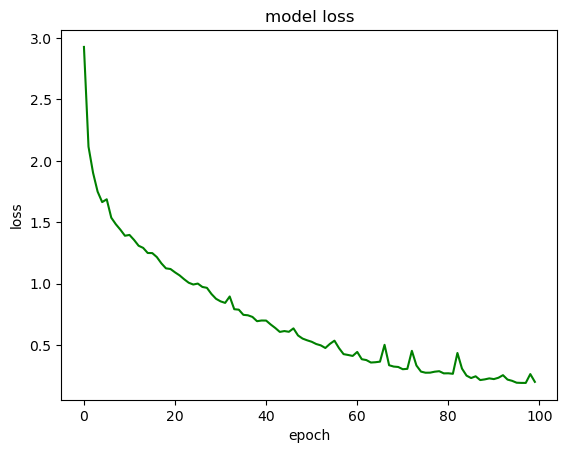

In [11]:
# ===================================================================================
#                                  Loss History Plot
# ===================================================================================

plt.title('model loss')
plt.plot(hybrid.history['loss'], '-g')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

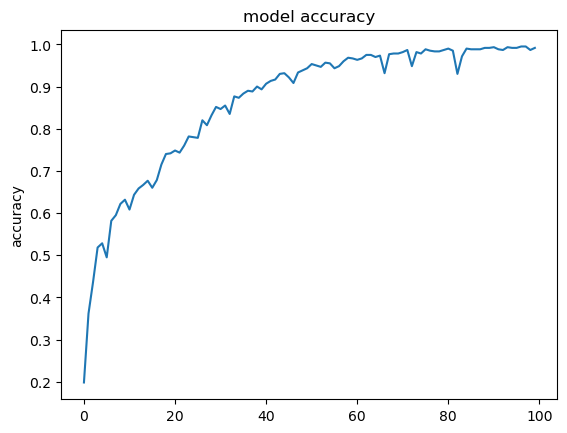

In [12]:
# ===================================================================================
#                                Accuracy History Plot
# ===================================================================================

plt.title('model accuracy')
plt.plot(hybrid.history['accuracy'], '-g')
plt.ylabel('accuracy')
plt.show()